Iniciando cálculo FEM...
Generando malla...
Malla generada: 4480 puntos, 8640 triángulos
Ensamblando matrices K y M...
Procesando triángulo 0/8640
Procesando triángulo 1000/8640
Procesando triángulo 2000/8640
Procesando triángulo 3000/8640
Procesando triángulo 4000/8640
Procesando triángulo 5000/8640
Procesando triángulo 6000/8640
Procesando triángulo 7000/8640
Procesando triángulo 8000/8640
Matrices K y M ensambladas
Ensamblando condiciones de contorno Robin...
Procesando arista 0/160
Procesando arista 100/160
Resolviendo sistema lineal...
Sistema resuelto
Generando gráficas...
Gráfica 1 guardada: campo_electrico_total.png
Calculando solución analítica...
Gráfica 2 guardada: comparacion_fem_analitica.png
Mostrando gráficas...


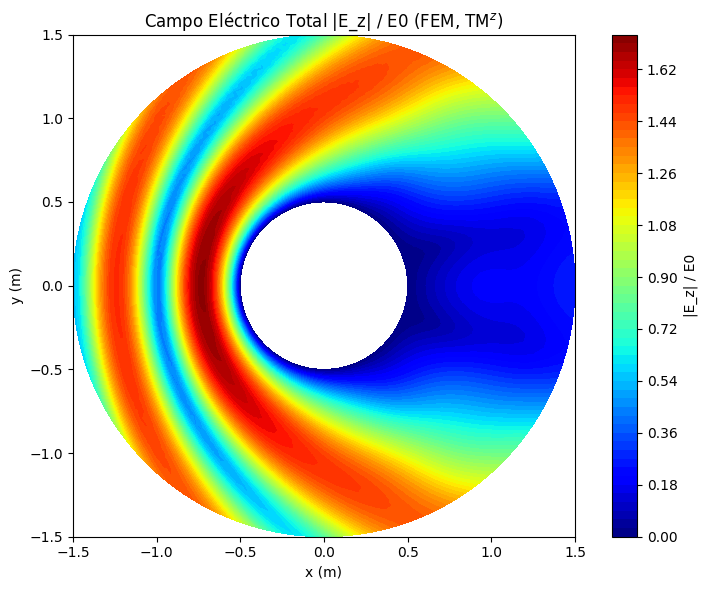

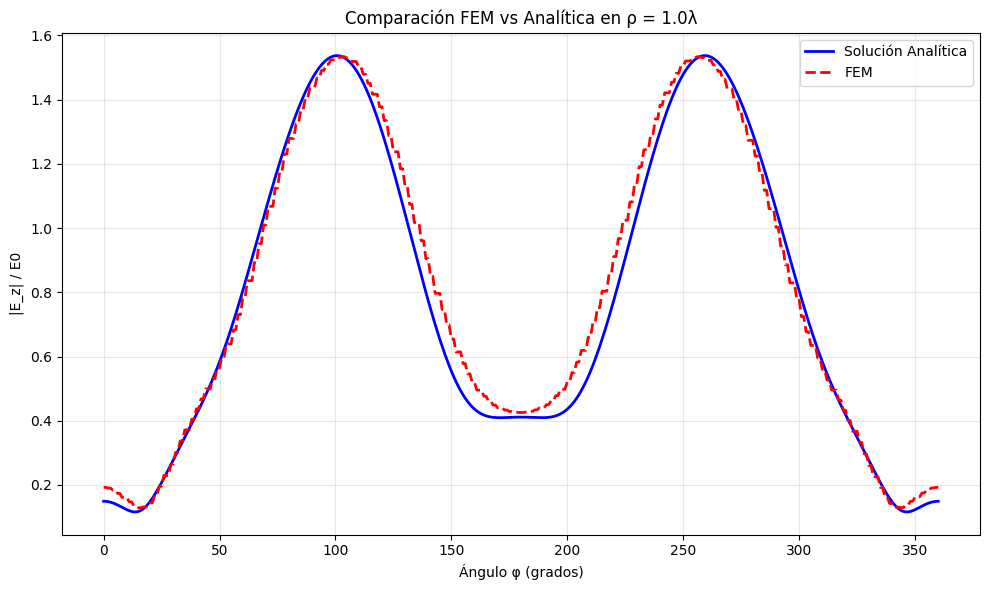

=== CÁLCULO COMPLETADO ===
Gráficas guardadas:
- campo_electrico_total.png
- comparacion_fem_analitica.png


In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.special import jv as Jn, hankel2

# Configurar matplotlib para VS Code
plt.ion()  # Modo interactivo

# ----------------------------
# Parámetros físicos / geometría
# ----------------------------
E0 = 1.0
lam = 1.0
k0 = 2.0 * np.pi / lam
a = 0.5 * lam  # radio interior (PEC)
R = 1.5 * lam  # radio exterior (ABC)
robin_coeff = 1j * k0 + 1.0 / (2.0 * R)  # ABC 1er orden en r=R

print("Iniciando cálculo FEM...")

# ----------------------------
# Malla de anillo "casera" (P1)
# ----------------------------
def annulus_mesh(R, a, n_r=28, n_theta=160):
    """Malla estructurada en (r,theta) -> 2 triángulos por celda"""
    rs = np.linspace(a, R, n_r)
    the = np.linspace(0, 2 * np.pi, n_theta, endpoint=False)
    rr, tt = np.meshgrid(rs, the, indexing='ij')
    x = (rr * np.cos(tt)).ravel()
    y = (rr * np.sin(tt)).ravel()
    pts = np.c_[x, y]
    
    def nid(i, j): 
        return i * n_theta + j  # i=0..n_r-1, j=0..n_theta-1
    
    tris = []
    for i in range(n_r - 1):
        for j in range(n_theta):
            jp = (j + 1) % n_theta
            n00 = nid(i, j)
            n10 = nid(i + 1, j)
            n01 = nid(i, jp)
            n11 = nid(i + 1, jp)
            tris.append([n00, n10, n11])
            tris.append([n00, n11, n01])
    
    tris = np.array(tris, dtype=int)
    
    # aristas de borde:
    inner_ring = [nid(0, j) for j in range(n_theta)]
    outer_ring = [nid(n_r - 1, j) for j in range(n_theta)]
    inner_edges = np.array([[inner_ring[j], inner_ring[(j + 1) % n_theta]] for j in range(n_theta)], dtype=int)
    outer_edges = np.array([[outer_ring[j], outer_ring[(j + 1) % n_theta]] for j in range(n_theta)], dtype=int)
    
    return pts, tris, inner_edges, outer_edges

print("Generando malla...")
pts, tris, inner_edges, outer_edges = annulus_mesh(R, a)
print(f"Malla generada: {pts.shape[0]} puntos, {tris.shape[0]} triángulos")

# ----------------------------
# Ensamble de K y M (P1) por triángulo
# ----------------------------
def assemble_K_M(pts, tris):
    N = pts.shape[0]
    K = lil_matrix((N, N), dtype=complex)
    M = lil_matrix((N, N), dtype=complex)
    Mloc = (1.0 / 12.0) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]], float)
    
    print("Ensamblando matrices K y M...")
    for idx, tri in enumerate(tris):
        if idx % 1000 == 0:
            print(f"Procesando triángulo {idx}/{len(tris)}")
            
        ids = tri
        x = pts[ids, 0]
        y = pts[ids, 1]
        A = np.array([[1, x[0], y[0]],
                      [1, x[1], y[1]],
                      [1, x[2], y[2]]], float)
        detA = np.linalg.det(A)
        area = 0.5 * abs(detA)
        
        if area <= 1e-20:
            continue
            
        invA = np.linalg.inv(A)
        b = invA[1, :]
        c = invA[2, :]  # grad φ_i = [b_i, c_i]
        Ke = area * (np.outer(b, b) + np.outer(c, c))
        Me = area * Mloc
        
        for i in range(3):
            I = ids[i]
            for j in range(3):
                J = ids[j]
                K[I, J] += Ke[i, j]
                M[I, J] += Me[i, j]
                
    return csr_matrix(K), csr_matrix(M)

K, M = assemble_K_M(pts, tris)
print("Matrices K y M ensambladas")

# ----------------------------
# Término de contorno (Robin) y RHS en Γ_R
# ----------------------------
def assemble_robin_and_rhs(pts, edges, robin_coeff, k0, E0):
    N = pts.shape[0]
    Arobin = lil_matrix((N, N), dtype=complex)
    b = np.zeros(N, dtype=complex)
    
    print("Ensamblando condiciones de contorno Robin...")
    for idx, (i, j) in enumerate(edges):
        if idx % 100 == 0:
            print(f"Procesando arista {idx}/{len(edges)}")
            
        xi, yi = pts[i]
        xj, yj = pts[j]
        Li = np.hypot(xj - xi, yj - yi)
        M1d = (Li / 6.0) * np.array([[2.0, 1.0], [1.0, 2.0]], complex)
        xm, ym = 0.5 * (xi + xj), 0.5 * (yi + yj)
        r = np.hypot(xm, ym)
        nx, ny = (xm / r, ym / r) if r > 0 else (1.0, 0.0)
        
        def Einc(x, y): 
            return E0 * np.exp(-1j * k0 * x)
            
        Ein_i, Ein_j = Einc(xi, yi), Einc(xj, yj)
        dEn_i = (-1j * k0) * nx * Ein_i
        dEn_j = (-1j * k0) * nx * Ein_j
        
        Arobin[i, i] += robin_coeff * M1d[0, 0]
        Arobin[i, j] += robin_coeff * M1d[0, 1]
        Arobin[j, i] += robin_coeff * M1d[1, 0]
        Arobin[j, j] += robin_coeff * M1d[1, 1]
        
        rhs_i = dEn_i + robin_coeff * Ein_i
        rhs_j = dEn_j + robin_coeff * Ein_j
        b[i] += M1d[0, 0] * rhs_i + M1d[0, 1] * rhs_j
        b[j] += M1d[1, 0] * rhs_i + M1d[1, 1] * rhs_j
        
    return csr_matrix(Arobin), b

Arobin, b_robin = assemble_robin_and_rhs(pts, outer_edges, robin_coeff, k0, E0)

# Matriz global y RHS global
A = K - (k0 ** 2) * M + Arobin
b = b_robin.copy()

# ----------------------------
# Dirichlet en PEC interior (u=0 en r=a)
# ----------------------------
inner_nodes = np.unique(inner_edges.ravel())
all_idx = np.arange(pts.shape[0])
free = np.setdiff1d(all_idx, inner_nodes)

# Condensación simple (imponemos u_inner = 0)
A_ff = A[free][:, free]
b_f = b[free]

print("Resolviendo sistema lineal...")
u_f = spsolve(A_ff, b_f)
u = np.zeros(pts.shape[0], dtype=complex)
u[free] = u_f
print("Sistema resuelto")

# ----------------------------
# GRAFICAR |E|/E0
# ----------------------------
print("Generando gráficas...")

# Figura 1: Campo eléctrico total
triang = Triangulation(pts[:, 0], pts[:, 1], tris)
vals = np.abs(u) / E0

plt.figure(figsize=(8, 6))
tcf = plt.tricontourf(triang, vals, 60, cmap='jet')
plt.colorbar(tcf, label='|E_z| / E0')
plt.gca().set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Campo Eléctrico Total |E_z| / E0 (FEM, TM$^z$)')
plt.tight_layout()
plt.savefig('campo_electrico_total.png', dpi=300, bbox_inches='tight')
print("Gráfica 1 guardada: campo_electrico_total.png")

# ----------------------------
# Comparación con solución analítica en ρ = λ
# ----------------------------
rho_eval = lam
phi = np.linspace(0, 2 * np.pi, 361)
x_eval = rho_eval * np.cos(phi)
y_eval = rho_eval * np.sin(phi)

# Interpolación mejorada
u_fem_curve = np.zeros_like(phi, dtype=complex)
for i, (x, y) in enumerate(zip(x_eval, y_eval)):
    # Encontrar el punto más cercano en la malla
    distances = np.sqrt((pts[:, 0] - x) ** 2 + (pts[:, 1] - y) ** 2)
    closest_idx = np.argmin(distances)
    u_fem_curve[i] = u[closest_idx]

# Solución analítica exacta
print("Calculando solución analítica...")
Nsum = 60
E_exact = np.zeros_like(phi, dtype=complex)
kr = k0 * rho_eval
ka = k0 * a

for n in range(-Nsum, Nsum + 1):
    Jn_kr = Jn(n, kr)
    Jn_ka = Jn(n, ka)
    Hn_ka = hankel2(n, ka)
    Hn_kr = hankel2(n, kr)
    coef = Jn_kr - (Jn_ka / Hn_ka) * Hn_kr
    E_exact += (1j) ** (-n) * coef * np.exp(1j * n * phi)
    
E_exact *= E0

# Figura 2: Comparación FEM vs Analítica
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(phi), np.abs(E_exact) / E0, 'b-', linewidth=2, label='Solución Analítica')
plt.plot(np.degrees(phi), np.abs(u_fem_curve) / E0, 'r--', linewidth=2, label='FEM')
plt.xlabel('Ángulo φ (grados)')
plt.ylabel('|E_z| / E0')
plt.title(f'Comparación FEM vs Analítica en ρ = {rho_eval}λ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparacion_fem_analitica.png', dpi=300, bbox_inches='tight')
print("Gráfica 2 guardada: comparacion_fem_analitica.png")

# ----------------------------
# Mostrar todas las gráficas
# ----------------------------
print("Mostrando gráficas...")
plt.show(block=True)  # Esto mantiene las ventanas abiertas

print("=== CÁLCULO COMPLETADO ===")
print("Gráficas guardadas:")
print("- campo_electrico_total.png")
print("- comparacion_fem_analitica.png")
